Mounting Google Drive...
Mounted at /content/drive

TEMPO AND ZERO CROSSING RATE ANALYSIS

Checking paths...
✓ JSON file found
✓ Signals folder found
✓ Unprocessed folder found

LOADING JSON METADATA
Loaded 8802 entries from JSON

📊 Hearing Loss Distribution:
  Mild: 2935 entries (33.3%)
  Moderate: 2934 entries (33.3%)
  No Loss: 2933 entries (33.3%)

📊 Correctness Statistics:
  Mean: 0.431
  Median: 0.400
  Std: 0.358

BUILDING AUDIO FILE INDEXES

Indexing signals folder...
✓ Indexed 9319 signal file references

Indexing unprocessed folder...
✓ Indexed 9319 unprocessed file references

PROCESSING JSON ENTRIES AND EXTRACTING FEATURES

📊 Processing 100 entries from JSON
   Total entries in JSON: 8802
   Limited to first: 100

Processing batch 1/2


Extracting Features: 100%|██████████| 50/50 [01:49<00:00,  2.20s/it]



Processing batch 2/2


Extracting Features: 100%|██████████| 50/50 [01:28<00:00,  1.78s/it]



📊 File Matching Statistics:
   Signals files found: 100/100
   Unprocessed files found: 100/100
   Both files found (paired): 100/100
   Signals files NOT found: 0
   Unprocessed files NOT found: 0

✅ Results saved to /content/audio_features.csv

SIMILARITY ANALYSIS: SIGNALS vs UNPROCESSED

Analyzing 100 paired files

📊 TEMPO SIMILARITY:
   Mean tempo difference: 4.67 BPM
   Median tempo difference: 0.00 BPM
   Mean % difference: 3.34%
   Std tempo difference: 10.45 BPM
   Correlation (unproc vs signals): 0.846 (p=0.0000)

📊 ZERO CROSSING RATE SIMILARITY:
   Mean ZCR mean difference: 0.034562
   Median ZCR mean difference: 0.024436
   Mean % difference: 34.06%
   Std ZCR mean difference: 0.037295
   Correlation (unproc vs signals): 0.392 (p=0.0001)

Similarity plots saved to /content/drive/MyDrive/feature_similarity_comparison.png


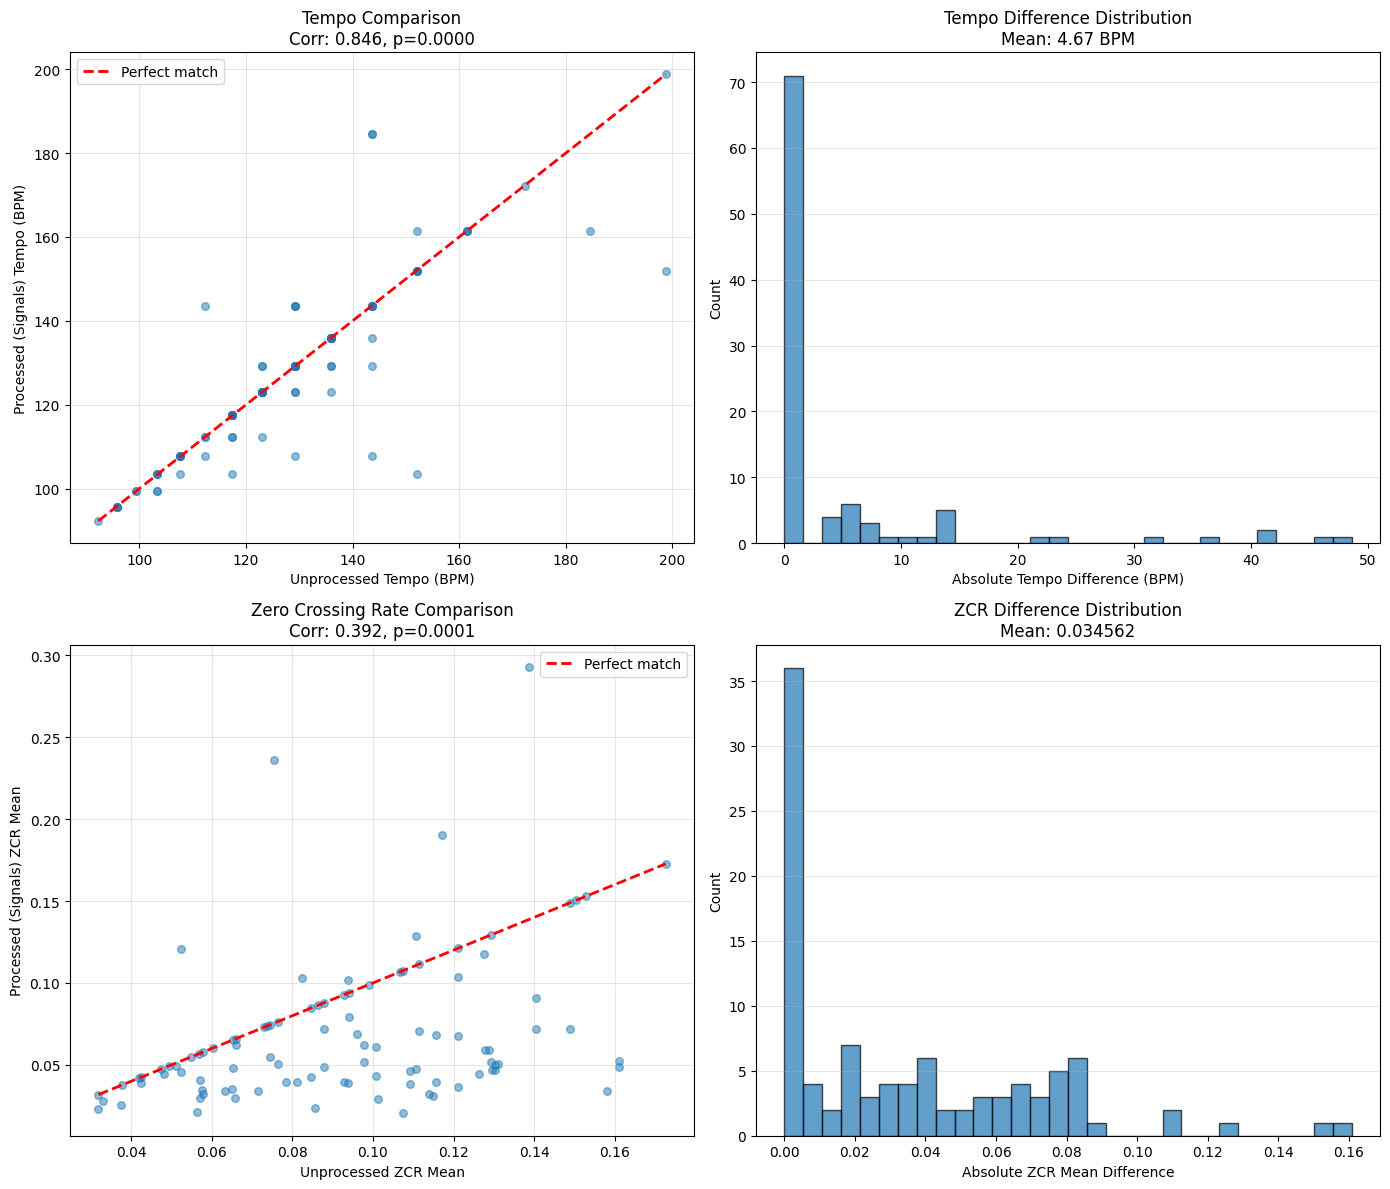


UNPROCESSED FEATURES AS PREDICTORS OF CORRECTNESS

Analyzing 100 samples with valid data

📊 UNPROCESSED TEMPO vs CORRECTNESS:
   Correlation: -0.0473
   P-value: 0.639925
   Significant: No (α=0.05)

📊 UNPROCESSED ZCR MEAN vs CORRECTNESS:
   Correlation: -0.1460
   P-value: 0.147197
   Significant: No (α=0.05)

📊 UNPROCESSED ZCR STD vs CORRECTNESS:
   Correlation: 0.1577
   P-value: 0.117082
   Significant: No (α=0.05)

Predictor plots saved to /content/drive/MyDrive/unproc_features_vs_correctness.png


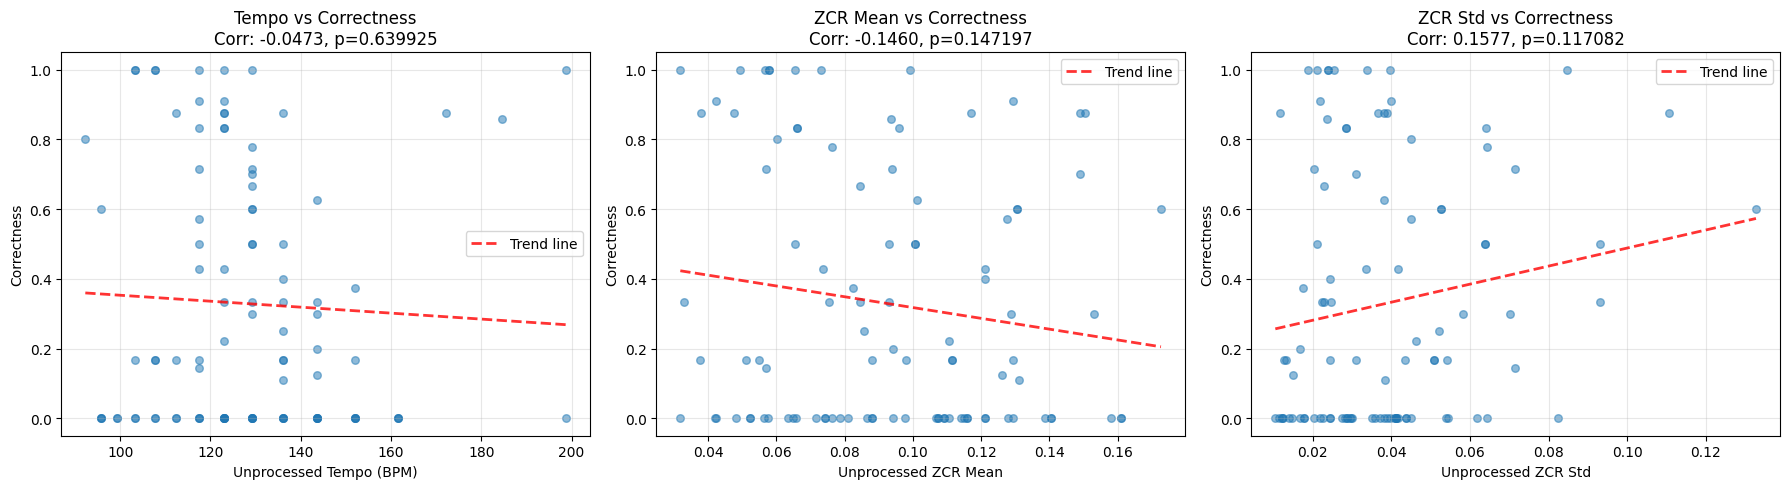


Correlation results saved to /content/drive/MyDrive/unproc_feature_correlations.csv

ANALYSIS BY HEARING LOSS LEVEL

Mild:
  Samples: 31
  Mean correctness: 0.328
  Std correctness: 0.330
  Mean unproc tempo: 125.60
  Mean unproc ZCR: 0.091776

Moderate:
  Samples: 38
  Mean correctness: 0.149
  Std correctness: 0.244
  Mean unproc tempo: 130.80
  Mean unproc ZCR: 0.099420

No Loss:
  Samples: 31
  Mean correctness: 0.550
  Std correctness: 0.408
  Mean unproc tempo: 127.83
  Mean unproc ZCR: 0.085654

✅ Feature data also saved to Drive: /content/drive/MyDrive/audio_features.csv

SAMPLE RESULTS (first 5 rows)
                  signal_id hearing_loss  correctness  unproc_tempo  signals_tempo  tempo_diff  unproc_zcr_mean  signals_zcr_mean  zcr_mean_diff
0  c221f2084c780e8f212f4697     Moderate     0.000000    151.999081     161.499023    9.499943         0.110614          0.128567       0.017953
1  63de05fbfcab2d7748b83cb3         Mild     0.166667    107.666016     103.359375    4.3066

In [1]:
# Google Colab version for Audio Feature Extraction and Correlation Analysis
# Extracts tempo and zero crossing rate features and correlates with lyrics prediction correctness

import json
import librosa
import numpy as np
import pandas as pd
import os
from typing import Dict, Optional, List, Tuple
from tqdm import tqdm
import tempfile
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
warnings.filterwarnings('ignore')

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

def load_json_data(file_path: str) -> list:
    """Load the JSON data from file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def extract_audio_features(audio_path: str, sr: int = 22050, duration: int = 30) -> Optional[Dict]:
    """
    Extract tempo (BPM) and zero crossing rate from an audio file using librosa

    Features extracted:
    - Tempo/BPM
    - Zero crossing rate (mean and std)

    Parameters:
    - audio_path: Path to the audio file
    - sr: Sample rate for loading audio
    - duration: Duration in seconds to analyze (None for full file)

    Returns:
    - Dictionary of features, or None if extraction fails
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        features = {}

        # 1. Tempo/BPM
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
        features['tempo'] = float(tempo[0])

        # 2. Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]
        features['zero_crossing_rate_mean'] = float(np.mean(zero_crossing_rate))
        features['zero_crossing_rate_std'] = float(np.std(zero_crossing_rate))

        return features

    except Exception as e:
        print(f"Error processing {os.path.basename(audio_path)}: {str(e)}")
        return None

def build_audio_file_index(folder_path: str) -> Dict[str, str]:
    """
    Build an index of all audio files in a folder
    Maps various ID formats to file paths for fast lookup

    Returns:
    - Dictionary mapping IDs to file paths
    """
    audio_index = {}
    audio_extensions = ('.mp3', '.wav', '.flac', '.m4a', '.ogg', '.aac')

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return audio_index

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(audio_extensions):
                file_path = os.path.join(root, file)
                base_name = os.path.splitext(file)[0]

                # Index by full basename
                audio_index[base_name] = file_path

                # If it contains _unproc, also index by the hash with _unproc
                if '_unproc' in base_name:
                    audio_index[base_name] = file_path

                # Also index by base without leading zeros
                audio_index[base_name.lstrip('0')] = file_path

    return audio_index

def process_json_entries(json_data: list, signals_index: Dict[str, str], unproc_index: Dict[str, str],
                        max_files: Optional[int] = None, batch_size: int = 50,
                        output_file: str = "audio_features.csv") -> pd.DataFrame:
    """
    Process JSON entries to extract tempo and zero crossing rate features

    Logic:
    - Uses signal_id to find files in BOTH folders:
      * Signals: <HASH_NUMBER>.flac
      * Unprocessed: <HASH_NUMBER>_unproc.flac
    - Extracts tempo and ZCR from both files
    - Calculates differences between processed and unprocessed
    - Includes correctness and hearing loss from JSON

    Parameters:
    - json_data: List of dictionaries from JSON file
    - signals_index: Dictionary mapping IDs to signals file paths
    - unproc_index: Dictionary mapping IDs to unprocessed file paths
    - max_files: Maximum number of files to process (None for all)
    - batch_size: Batch size for processing
    - output_file: Path to save results

    Returns:
    - DataFrame with features and metadata
    """
    results = []

    # Limit entries if max_files specified
    entries_to_process = json_data[:max_files] if max_files else json_data
    total_entries = len(entries_to_process)

    print(f"\n📊 Processing {total_entries} entries from JSON")
    print(f"   Total entries in JSON: {len(json_data)}")
    if max_files:
        print(f"   Limited to first: {max_files}")

    # Track statistics
    files_found = {'signals': 0, 'unproc': 0, 'both': 0}
    files_not_found = {'signals': 0, 'unproc': 0}

    # Process in batches
    for batch_start in range(0, total_entries, batch_size):
        batch_end = min(batch_start + batch_size, total_entries)
        batch = entries_to_process[batch_start:batch_end]

        print(f"\nProcessing batch {batch_start//batch_size + 1}/{(total_entries-1)//batch_size + 1}")

        for entry in tqdm(batch, desc="Extracting Features"):
            signal_id = entry.get('signal', '')
            fma_id = entry.get('fma', '')
            hearing_loss = entry.get('hearing_loss', 'Unknown')
            correctness = entry.get('correctness', 0.0)
            n_words = entry.get('n_words', 0)
            words_correct = entry.get('words_correct', 0)

            # Use signal_id to find file in signals folder
            signals_path = None
            if signal_id in signals_index:
                signals_path = signals_index[signal_id]

            # Use signal_id to find file in unprocessed folder (with _unproc suffix)
            unproc_path = None
            unproc_key = f"{signal_id}_unproc"
            if unproc_key in unproc_index:
                unproc_path = unproc_index[unproc_key]
            elif signal_id in unproc_index:
                unproc_path = unproc_index[signal_id]

            # Track what we found
            if signals_path:
                files_found['signals'] += 1
            else:
                files_not_found['signals'] += 1

            if unproc_path:
                files_found['unproc'] += 1
            else:
                files_not_found['unproc'] += 1

            if signals_path and unproc_path:
                files_found['both'] += 1

            # Extract features
            signals_features = extract_audio_features(signals_path) if signals_path else None
            unproc_features = extract_audio_features(unproc_path) if unproc_path else None

            # Build result row
            result = {
                'signal_id': signal_id,
                'fma_id': fma_id,
                'hearing_loss': hearing_loss,
                'correctness': correctness,
                'n_words': n_words,
                'words_correct': words_correct,
                'signals_file': os.path.basename(signals_path) if signals_path else 'NOT_FOUND',
                'unproc_file': os.path.basename(unproc_path) if unproc_path else 'NOT_FOUND',
            }

            # Add signals features
            if signals_features:
                result['signals_tempo'] = signals_features['tempo']
                result['signals_zcr_mean'] = signals_features['zero_crossing_rate_mean']
                result['signals_zcr_std'] = signals_features['zero_crossing_rate_std']

            # Add unproc features
            if unproc_features:
                result['unproc_tempo'] = unproc_features['tempo']
                result['unproc_zcr_mean'] = unproc_features['zero_crossing_rate_mean']
                result['unproc_zcr_std'] = unproc_features['zero_crossing_rate_std']

            # Calculate feature differences and similarity
            if signals_features and unproc_features:
                result['tempo_diff'] = abs(signals_features['tempo'] - unproc_features['tempo'])
                result['tempo_pct_diff'] = (result['tempo_diff'] / unproc_features['tempo'] * 100) if unproc_features['tempo'] > 0 else 0

                result['zcr_mean_diff'] = abs(signals_features['zero_crossing_rate_mean'] - unproc_features['zero_crossing_rate_mean'])
                result['zcr_mean_pct_diff'] = (result['zcr_mean_diff'] / unproc_features['zero_crossing_rate_mean'] * 100) if unproc_features['zero_crossing_rate_mean'] > 0 else 0

                result['zcr_std_diff'] = abs(signals_features['zero_crossing_rate_std'] - unproc_features['zero_crossing_rate_std'])

            results.append(result)

        # Save intermediate results
        df_temp = pd.DataFrame(results)
        df_temp.to_csv(f"{output_file}.tmp", index=False)

    # Print file matching statistics
    print(f"\n📊 File Matching Statistics:")
    print(f"   Signals files found: {files_found['signals']}/{total_entries}")
    print(f"   Unprocessed files found: {files_found['unproc']}/{total_entries}")
    print(f"   Both files found (paired): {files_found['both']}/{total_entries}")
    print(f"   Signals files NOT found: {files_not_found['signals']}")
    print(f"   Unprocessed files NOT found: {files_not_found['unproc']}")

    # Save final results
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"\n✅ Results saved to {output_file}")

    return df

def analyze_similarity(df: pd.DataFrame, output_dir: str = "/content/drive/MyDrive"):
    """
    Analyze similarity between processed and unprocessed features
    """
    print("\n" + "="*60)
    print("SIMILARITY ANALYSIS: SIGNALS vs UNPROCESSED")
    print("="*60)

    # Filter to rows where both files exist
    paired_df = df[(df['signals_file'] != 'NOT_FOUND') & (df['unproc_file'] != 'NOT_FOUND')].copy()

    if len(paired_df) == 0:
        print("No paired files found for similarity analysis")
        return

    print(f"\nAnalyzing {len(paired_df)} paired files")

    # Tempo similarity
    print("\n📊 TEMPO SIMILARITY:")
    print(f"   Mean tempo difference: {paired_df['tempo_diff'].mean():.2f} BPM")
    print(f"   Median tempo difference: {paired_df['tempo_diff'].median():.2f} BPM")
    print(f"   Mean % difference: {paired_df['tempo_pct_diff'].mean():.2f}%")
    print(f"   Std tempo difference: {paired_df['tempo_diff'].std():.2f} BPM")

    # Calculate correlation between unproc and signals tempo
    tempo_corr, tempo_p = stats.pearsonr(paired_df['unproc_tempo'].dropna(),
                                          paired_df['signals_tempo'].dropna())
    print(f"   Correlation (unproc vs signals): {tempo_corr:.3f} (p={tempo_p:.4f})")

    # Zero Crossing Rate similarity
    print("\n📊 ZERO CROSSING RATE SIMILARITY:")
    print(f"   Mean ZCR mean difference: {paired_df['zcr_mean_diff'].mean():.6f}")
    print(f"   Median ZCR mean difference: {paired_df['zcr_mean_diff'].median():.6f}")
    print(f"   Mean % difference: {paired_df['zcr_mean_pct_diff'].mean():.2f}%")
    print(f"   Std ZCR mean difference: {paired_df['zcr_mean_diff'].std():.6f}")

    # Calculate correlation between unproc and signals ZCR
    zcr_corr, zcr_p = stats.pearsonr(paired_df['unproc_zcr_mean'].dropna(),
                                      paired_df['signals_zcr_mean'].dropna())
    print(f"   Correlation (unproc vs signals): {zcr_corr:.3f} (p={zcr_p:.4f})")

    # Create similarity visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Tempo scatter plot
    ax = axes[0, 0]
    ax.scatter(paired_df['unproc_tempo'], paired_df['signals_tempo'], alpha=0.5, s=30)
    ax.plot([paired_df['unproc_tempo'].min(), paired_df['unproc_tempo'].max()],
            [paired_df['unproc_tempo'].min(), paired_df['unproc_tempo'].max()],
            'r--', linewidth=2, label='Perfect match')
    ax.set_xlabel('Unprocessed Tempo (BPM)')
    ax.set_ylabel('Processed (Signals) Tempo (BPM)')
    ax.set_title(f'Tempo Comparison\nCorr: {tempo_corr:.3f}, p={tempo_p:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Tempo difference histogram
    ax = axes[0, 1]
    ax.hist(paired_df['tempo_diff'], bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Absolute Tempo Difference (BPM)')
    ax.set_ylabel('Count')
    ax.set_title(f'Tempo Difference Distribution\nMean: {paired_df["tempo_diff"].mean():.2f} BPM')
    ax.grid(True, alpha=0.3, axis='y')

    # ZCR scatter plot
    ax = axes[1, 0]
    ax.scatter(paired_df['unproc_zcr_mean'], paired_df['signals_zcr_mean'], alpha=0.5, s=30)
    ax.plot([paired_df['unproc_zcr_mean'].min(), paired_df['unproc_zcr_mean'].max()],
            [paired_df['unproc_zcr_mean'].min(), paired_df['unproc_zcr_mean'].max()],
            'r--', linewidth=2, label='Perfect match')
    ax.set_xlabel('Unprocessed ZCR Mean')
    ax.set_ylabel('Processed (Signals) ZCR Mean')
    ax.set_title(f'Zero Crossing Rate Comparison\nCorr: {zcr_corr:.3f}, p={zcr_p:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ZCR difference histogram
    ax = axes[1, 1]
    ax.hist(paired_df['zcr_mean_diff'], bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Absolute ZCR Mean Difference')
    ax.set_ylabel('Count')
    ax.set_title(f'ZCR Difference Distribution\nMean: {paired_df["zcr_mean_diff"].mean():.6f}')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    similarity_plot = os.path.join(output_dir, "feature_similarity_comparison.png")
    plt.savefig(similarity_plot, dpi=300, bbox_inches='tight')
    print(f"\nSimilarity plots saved to {similarity_plot}")
    plt.show()

def analyze_unproc_predictors(df: pd.DataFrame, output_dir: str = "/content/drive/MyDrive"):
    """
    Analyze if unprocessed tempo and ZCR are good predictors of correctness
    """
    print("\n" + "="*60)
    print("UNPROCESSED FEATURES AS PREDICTORS OF CORRECTNESS")
    print("="*60)

    # Filter to rows with unprocessed features
    unproc_df = df[df['unproc_file'] != 'NOT_FOUND'].copy()

    if len(unproc_df) == 0:
        print("No unprocessed files found for prediction analysis")
        return

    # Convert to numeric
    for col in ['unproc_tempo', 'unproc_zcr_mean', 'unproc_zcr_std', 'correctness']:
        unproc_df[col] = pd.to_numeric(unproc_df[col], errors='coerce')

    # Remove rows with NaN values
    valid_df = unproc_df[['unproc_tempo', 'unproc_zcr_mean', 'unproc_zcr_std', 'correctness']].dropna()

    print(f"\nAnalyzing {len(valid_df)} samples with valid data")

    # Tempo correlation with correctness
    tempo_corr, tempo_p = stats.pearsonr(valid_df['unproc_tempo'], valid_df['correctness'])
    print(f"\n📊 UNPROCESSED TEMPO vs CORRECTNESS:")
    print(f"   Correlation: {tempo_corr:.4f}")
    print(f"   P-value: {tempo_p:.6f}")
    print(f"   Significant: {'Yes' if tempo_p < 0.05 else 'No'} (α=0.05)")

    # ZCR mean correlation with correctness
    zcr_mean_corr, zcr_mean_p = stats.pearsonr(valid_df['unproc_zcr_mean'], valid_df['correctness'])
    print(f"\n📊 UNPROCESSED ZCR MEAN vs CORRECTNESS:")
    print(f"   Correlation: {zcr_mean_corr:.4f}")
    print(f"   P-value: {zcr_mean_p:.6f}")
    print(f"   Significant: {'Yes' if zcr_mean_p < 0.05 else 'No'} (α=0.05)")

    # ZCR std correlation with correctness
    zcr_std_corr, zcr_std_p = stats.pearsonr(valid_df['unproc_zcr_std'], valid_df['correctness'])
    print(f"\n📊 UNPROCESSED ZCR STD vs CORRECTNESS:")
    print(f"   Correlation: {zcr_std_corr:.4f}")
    print(f"   P-value: {zcr_std_p:.6f}")
    print(f"   Significant: {'Yes' if zcr_std_p < 0.05 else 'No'} (α=0.05)")

    # Create prediction visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Tempo vs Correctness
    ax = axes[0]
    ax.scatter(valid_df['unproc_tempo'], valid_df['correctness'], alpha=0.5, s=30)
    ax.set_xlabel('Unprocessed Tempo (BPM)')
    ax.set_ylabel('Correctness')
    ax.set_title(f'Tempo vs Correctness\nCorr: {tempo_corr:.4f}, p={tempo_p:.6f}')
    ax.grid(True, alpha=0.3)
    # Add trend line
    z = np.polyfit(valid_df['unproc_tempo'], valid_df['correctness'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_df['unproc_tempo'].min(), valid_df['unproc_tempo'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
    ax.legend()

    # ZCR Mean vs Correctness
    ax = axes[1]
    ax.scatter(valid_df['unproc_zcr_mean'], valid_df['correctness'], alpha=0.5, s=30)
    ax.set_xlabel('Unprocessed ZCR Mean')
    ax.set_ylabel('Correctness')
    ax.set_title(f'ZCR Mean vs Correctness\nCorr: {zcr_mean_corr:.4f}, p={zcr_mean_p:.6f}')
    ax.grid(True, alpha=0.3)
    # Add trend line
    z = np.polyfit(valid_df['unproc_zcr_mean'], valid_df['correctness'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_df['unproc_zcr_mean'].min(), valid_df['unproc_zcr_mean'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
    ax.legend()

    # ZCR Std vs Correctness
    ax = axes[2]
    ax.scatter(valid_df['unproc_zcr_std'], valid_df['correctness'], alpha=0.5, s=30)
    ax.set_xlabel('Unprocessed ZCR Std')
    ax.set_ylabel('Correctness')
    ax.set_title(f'ZCR Std vs Correctness\nCorr: {zcr_std_corr:.4f}, p={zcr_std_p:.6f}')
    ax.grid(True, alpha=0.3)
    # Add trend line
    z = np.polyfit(valid_df['unproc_zcr_std'], valid_df['correctness'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_df['unproc_zcr_std'].min(), valid_df['unproc_zcr_std'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
    ax.legend()

    plt.tight_layout()
    predictor_plot = os.path.join(output_dir, "unproc_features_vs_correctness.png")
    plt.savefig(predictor_plot, dpi=300, bbox_inches='tight')
    print(f"\nPredictor plots saved to {predictor_plot}")
    plt.show()

    # Save correlation results
    corr_results = pd.DataFrame({
        'feature': ['unproc_tempo', 'unproc_zcr_mean', 'unproc_zcr_std'],
        'correlation': [tempo_corr, zcr_mean_corr, zcr_std_corr],
        'p_value': [tempo_p, zcr_mean_p, zcr_std_p],
        'significant': [tempo_p < 0.05, zcr_mean_p < 0.05, zcr_std_p < 0.05],
        'n_samples': [len(valid_df)] * 3
    })

    corr_output = os.path.join(output_dir, "unproc_feature_correlations.csv")
    corr_results.to_csv(corr_output, index=False)
    print(f"\nCorrelation results saved to {corr_output}")

    return corr_results

def analyze_by_hearing_loss(df: pd.DataFrame, output_dir: str = "/content/drive/MyDrive"):
    """
    Analyze features and correlations by hearing loss level
    """
    print("\n" + "="*60)
    print("ANALYSIS BY HEARING LOSS LEVEL")
    print("="*60)

    hearing_loss_levels = sorted([h for h in df['hearing_loss'].unique() if h != 'Unknown'])

    for loss_level in hearing_loss_levels:
        subset = df[df['hearing_loss'] == loss_level]

        if len(subset) > 10:
            print(f"\n{loss_level}:")
            print(f"  Samples: {len(subset)}")
            print(f"  Mean correctness: {subset['correctness'].mean():.3f}")
            print(f"  Std correctness: {subset['correctness'].std():.3f}")

            # Get tempo if available
            if 'unproc_tempo' in subset.columns:
                tempo_valid = subset['unproc_tempo'].dropna()
                if len(tempo_valid) > 0:
                    print(f"  Mean unproc tempo: {tempo_valid.mean():.2f}")

            # Get ZCR if available
            if 'unproc_zcr_mean' in subset.columns:
                zcr_valid = subset['unproc_zcr_mean'].dropna()
                if len(zcr_valid) > 0:
                    print(f"  Mean unproc ZCR: {zcr_valid.mean():.6f}")

# =====================================
# MAIN EXECUTION
# =====================================

# Configuration parameters
JSON_PATH = "/content/drive/MyDrive/Cadenza/cadenza_data/metadata/train_metadata.json"
SIGNALS_FOLDER = "/content/drive/MyDrive/Cadenza/cadenza_data/train/signals"
UNPROC_FOLDER = "/content/drive/MyDrive/Cadenza/cadenza_data/train/unprocessed"
MAX_FILES = 100  # Maximum number of files to process (set to None to process all files)

print("\n" + "="*60)
print("TEMPO AND ZERO CROSSING RATE ANALYSIS")
print("="*60)

# Check if paths exist
print("\nChecking paths...")
if not os.path.exists(JSON_PATH):
    print(f"❌ JSON file not found at: {JSON_PATH}")
    print("Cannot proceed without JSON file.")
else:
    print(f"✓ JSON file found")

if not os.path.exists(SIGNALS_FOLDER):
    print(f"⚠️  Signals folder not found at: {SIGNALS_FOLDER}")
else:
    print(f"✓ Signals folder found")

if not os.path.exists(UNPROC_FOLDER):
    print(f"⚠️  Unprocessed folder not found at: {UNPROC_FOLDER}")
else:
    print(f"✓ Unprocessed folder found")

# Proceed only if JSON file exists
if os.path.exists(JSON_PATH) and os.path.exists(SIGNALS_FOLDER) and os.path.exists(UNPROC_FOLDER):

    # Load JSON data
    print("\n" + "="*60)
    print("LOADING JSON METADATA")
    print("="*60)
    json_data = load_json_data(JSON_PATH)
    print(f"Loaded {len(json_data)} entries from JSON")

    # Show hearing loss distribution
    hearing_loss_counts = {}
    for entry in json_data:
        loss = entry.get('hearing_loss', 'Unknown')
        hearing_loss_counts[loss] = hearing_loss_counts.get(loss, 0) + 1

    print(f"\n📊 Hearing Loss Distribution:")
    for loss_level, count in sorted(hearing_loss_counts.items()):
        print(f"  {loss_level}: {count} entries ({100*count/len(json_data):.1f}%)")

    # Show correctness distribution
    correctness_values = [entry.get('correctness', 0.0) for entry in json_data]
    print(f"\n📊 Correctness Statistics:")
    print(f"  Mean: {np.mean(correctness_values):.3f}")
    print(f"  Median: {np.median(correctness_values):.3f}")
    print(f"  Std: {np.std(correctness_values):.3f}")

    # Build audio file indexes
    print("\n" + "="*60)
    print("BUILDING AUDIO FILE INDEXES")
    print("="*60)

    print("\nIndexing signals folder...")
    signals_index = build_audio_file_index(SIGNALS_FOLDER)
    print(f"✓ Indexed {len(signals_index)} signal file references")

    print("\nIndexing unprocessed folder...")
    unproc_index = build_audio_file_index(UNPROC_FOLDER)
    print(f"✓ Indexed {len(unproc_index)} unprocessed file references")

    # Process JSON entries
    print("\n" + "="*60)
    print("PROCESSING JSON ENTRIES AND EXTRACTING FEATURES")
    print("="*60)

    OUTPUT_FILE = "/content/audio_features.csv"
    features_df = process_json_entries(json_data, signals_index, unproc_index,
                                       max_files=MAX_FILES, batch_size=50,
                                       output_file=OUTPUT_FILE)

    if len(features_df) > 0:
        # Analyze similarity between processed and unprocessed
        analyze_similarity(features_df, output_dir="/content/drive/MyDrive")

        # Analyze unprocessed features as predictors of correctness
        corr_df = analyze_unproc_predictors(features_df, output_dir="/content/drive/MyDrive")

        # Analyze by hearing loss
        analyze_by_hearing_loss(features_df, output_dir="/content/drive/MyDrive")

        # Save to Drive
        drive_output = "/content/drive/MyDrive/audio_features.csv"
        features_df.to_csv(drive_output, index=False)
        print(f"\n✅ Feature data also saved to Drive: {drive_output}")

        # Show sample results
        print("\n" + "="*60)
        print("SAMPLE RESULTS (first 5 rows)")
        print("="*60)
        key_cols = ['signal_id', 'hearing_loss', 'correctness',
                   'unproc_tempo', 'signals_tempo', 'tempo_diff',
                   'unproc_zcr_mean', 'signals_zcr_mean', 'zcr_mean_diff']
        available_cols = [col for col in key_cols if col in features_df.columns]
        print(features_df[available_cols].head().to_string())
    else:
        print("\n⚠️  No data to analyze.")
else:
    print("\n❌ Please ensure all required paths exist and try again.")